In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict CAD/JPY exchange rate returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.tail()


,Price,Open,High,Low
Date,,,,
2020-05-29,78.29,78.21,78.41,77.75
2020-06-01,79.27,78.21,79.36,78.04
2020-06-02,80.40,79.26,80.56,79.15
2020-06-03,80.70,80.40,80.82,79.96
2020-06-04,80.71,80.80,80.89,80.51


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
# Created a series using "Price" percentage returns, dropped any nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns = returns.replace(np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
cad_jpy_df['Return']=cad_jpy_df.Price.pct_change() * 100
cad_jpy_df['Lagged_Return']=cad_jpy_df.Return.shift(periods=1)
cad_jpy_df=cad_jpy_df.replace(-np.inf, np.nan).dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [8]:
X_train.head()

,Lagged_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


In [9]:
y_train.head()

Date
1990-01-04   -1.468476
1990-01-05    0.874777
1990-01-08   -0.216798
1990-01-09    0.667901
1990-01-10    0.567546
Name: Return, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000196C76F5888>,
      dtype=object)

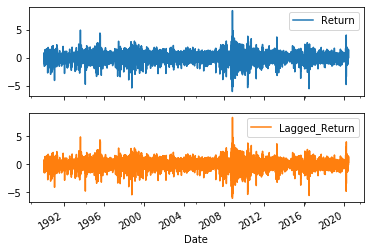

In [10]:
cad_jpy_df[['Return','Lagged_Return']].plot(subplots=True)

# Linear Regression Model

In [11]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.0006460903995160194


# Low R2 confirms low predictive power of lagged returns

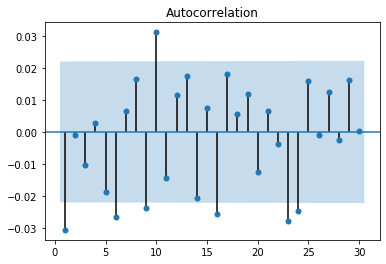

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(cad_jpy_df['Return'], lags=30,zero=False);

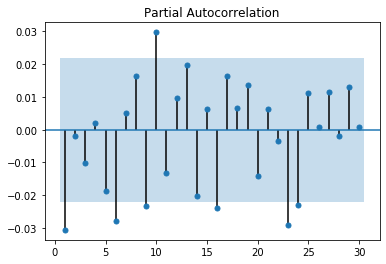

In [14]:
plot_pacf(cad_jpy_df['Return'], lags=30, zero=False);

### ACF and PACF plots confirm that FX returns is not an AR(1) process. For AR(1) process the ACF should decay gradually and PACF should drop to zero beyond 1 lag. Hence any regression of lagged returns on returns will be spurios

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Regressing lagged returns is akin to creating an AR(1) model
model1 = ARMA(cad_jpy_df.Return, order=(1, 0))
results = model1.fit()
results.summary()

C:\Users\amuni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                 7927
Model:                     ARMA(1, 0)   Log Likelihood               -9751.023
Method:                       css-mle   S.D. of innovations              0.828
Date:                Tue, 18 Aug 2020   AIC                          19508.047
Time:                        14:29:07   BIC                          19528.981
Sample:                             0   HQIC                         19515.215
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0021      0.009     -0.233      0.816      -0.020       0.016
ar.L1.Return    -0.0306      0.011     -2.726      0.006      -0.053      -0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -32.6669           +0.0000j           32.6669            0.5000
-----------------------------------------------------------------------------
"""

In [16]:
# Testing with 10 lags per ACF and PACF
model2 = ARMA(cad_jpy_df.Return, order=(10, 0))
results = model2.fit()
results.summary()

C:\Users\amuni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                 7927
Model:                    ARMA(10, 0)   Log Likelihood               -9739.226
Method:                       css-mle   S.D. of innovations              0.827
Date:                Tue, 18 Aug 2020   AIC                          19502.451
Time:                        14:29:08   BIC                          19586.188
Sample:                             0   HQIC                         19531.126
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0021      0.009     -0.241      0.810      -0.019       0.015
ar.L1.Return     -0.0300      0.011     -2.673      0.008      -0.052      -0.008
ar.L2.Return     -0.0022      0.011     -0.197      0.844      -0.024       0.020
ar.L3.Return     -0.0110      0.011     -0.983      0.326      -0.033       0.011
ar.L4.Return      0.0019      0.011      0.167      0.868      -0.020       0.024
ar.L5.Return     -0.0188      0.011     -1.677      0.094      -0.041       0.003
ar.L6.Return     -0.0281      0.011     -2.501      0.012      -0.050      -0.006
ar.L7.Return      0.0058      0.011      0.515      0.607      -0.016       0.028
ar.L8.Return      0.0158      0.011      1.406      0.160      -0.006       0.038
ar.L9.Return     -0.0225      0.011     -2.001      0.045      -0.044      -0.000
ar.L10.Return     0.0297      0.011      2.645      0.008       0.008       0.052
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.3438           -0.0000j            1.3438           -0.5000
AR.2            -1.0746           -0.8100j            1.3457           -0.3972
AR.3            -1.0746           +0.8100j            1.3457            0.3972
AR.4            -0.3182           -1.3464j            1.3835           -0.2869
AR.5            -0.3182           +1.3464j            1.3835            0.2869
AR.6             1.5247           -0.0000j            1.5247           -0.0000
AR.7             1.1713           -0.8333j            1.4375           -0.0984
AR.8             1.1713           +0.8333j            1.4375            0.0984
AR.9             0.5093           -1.4265j            1.5147           -0.1954
AR.10            0.5093           +1.4265j            1.5147            0.1954
------------------------------------------------------------------------------
"""

## Running an AR(10) model demonstrated the higher lags statistically significant impact. Thus regressing just lagged returns results in a weak regression with a low R2 and limited predictive power as evidenced

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [17]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [18]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000196CB1147C8>,
      dtype=object)

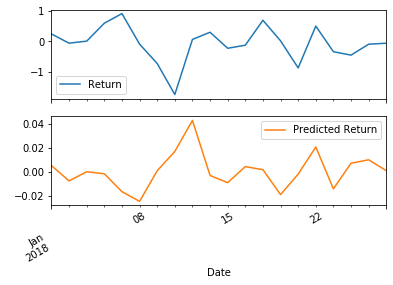

In [19]:
# Plot the first 20 predictions vs the true values
Results.head(20).plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [20]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(Results.Return, Results['Predicted Return'])
mse

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
rmse

0.6445805658569028

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [21]:
# Construct a dataframe using just the "y" training data:
Results_Train = y_train.to_frame()
#model = LinearRegression()
#model.fit(X_train, y_train)

# Add a column of "in-sample" predictions to that dataframe:

Results_Train['in-sample predictions']=model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
insample_mse = mean_squared_error(Results_Train.Return, Results_Train['in-sample predictions'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
insample_rmse = np.sqrt(insample_mse)
insample_rmse

0.841994632894117

coefficient of determination: 0.002915785295953266
New RMSE:  0.6444068716223972


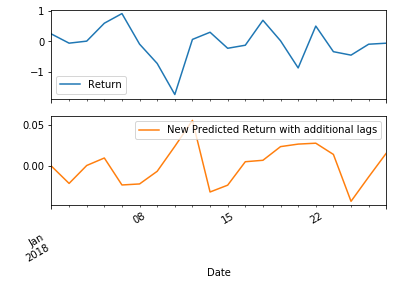

In [22]:
MultiRegDF=cad_jpy_df.copy()
MultiRegDF['Lag 6']=MultiRegDF.Return.shift(periods=6)
MultiRegDF['Lag 9']=MultiRegDF.Return.shift(periods=9)
MultiRegDF['Lag 10']=MultiRegDF.Return.shift(periods=10)
train_new = MultiRegDF[:'2017']
test_new = MultiRegDF['2018':]
X_train_new = train_new[["Lagged_Return","Lag 6","Lag 9","Lag 10"]]
X_test_new = test_new[["Lagged_Return","Lag 6","Lag 9","Lag 10"]]
y_train_new = train_new["Return"]
y_test_new = test_new["Return"]
X_train_new=X_train_new.dropna()
X_test_new=X_test_new.dropna()

y_train_new=y_train_new.iloc[10:]
y_train_new.head()

model_new = LinearRegression()
model_new.fit(X_train_new, y_train_new)

r_sq_new = model_new.score(X_train_new, y_train_new)
print('coefficient of determination:', r_sq_new)

predictions_new_regression = model_new.predict(X_test_new)
Results_new = y_test.to_frame()
Results_new["New Predicted Return with additional lags"] = predictions_new_regression
Results_new.head(20).plot(subplots=True)

mse_new = mean_squared_error(Results_new.Return, Results_new['New Predicted Return with additional lags'])
rmse_new = np.sqrt(mse_new)
print("New RMSE: ", rmse_new)

### Improvement in R2 after including additional lags from ARMA. Regression still remains very weak.

# Conclusions

YOUR CONCLUSIONS HERE!

## 1. Regressing lagged returns to returns similar to an AR(1) process
### 2. As evidenced by ACF, PACF and ARMA (1,0) and ARMA(10,0) outputs the JPY/CAD FX pair is not well represented by an AR(1) process
### 3. AR(10) outputs indicates atleast additional lags including 6,9 and 10 that are statistically significant ()
### 4. All of this results in a low R2 and high insample and out of sample RMSE
# In summary utilizing lagged returns to predict future returns does not provide any statistically significant information advantage.
